<a href="https://colab.research.google.com/github/wesleybeckner/technology_fundamentals/blob/main/C3%20Machine%20Learning%20I/Tech_Fun_C3_S3_The_Multilayer_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Technology Fundamentals Course 3, Session 3: The Multilayer Perceptron

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

**Teaching Assitants**: Varsha Bang, Harsha Vardhan

**Contact**: vbang@uw.edu, harshav@uw.edu

<br>

---

<br>

In this session we will introduce NEURAL NETWORKS! We'll cover the over arching concepts used to talk about network architecture as well as their building blocks.

_images in this notebook borrowed from [Ryan Holbrook](https://mathformachines.com/)_

<br>

---

<br>

<a name='top'></a>

# Contents

* 1.0 [Preparing Environment and Importing Data](#x.0)
  * 1.0.1 [Import Packages](#x.0.1)
  * 1.0.2 [Load Dataset](#x.0.2)
* 1.1 [Neural Network Architectures](#x.1)
  * 1.1.1 [Input, Output, and Hidden Layers](#x.1.1)
  * 1.1.2 [Feed Forward](#x.1.2)
  * 1.1.3 [Recurrent](#x.1.3)
  * 1.1.4 [Convolutional](#x.1.4)
* 1.2 [Neural Network Building Blocks](#x.2)
  * 1.2.1 [Assigning Blame](#x.2.1)
  * 1.2.2 [Chain Rule](#x.2.2)
  * 1.2.3 [Back-Propagation](#x.2.3)
  * 1.2.4 [Maximum Likelihood Estimation](#x.2.4)
    * 1.2.4.1 [Linear Regression as Maximum Likelihood](#x.2.4.1)
  * 1.2.5 [Activation Functions](#x.2.5)
* 1.3 [Enrichment: Program Your Own Neural Network](#x.3)
  

<br>

---

<a name='x.0'></a>

## 1.0 Preparing Environment and Importing Data

[back to top](#top)

In [5]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


<a name='x.0.1'></a>

### 1.0.1 Import Packages

[back to top](#top)

In [6]:
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
import plotly.express as px

from sklearn.impute import SimpleImputer
from copy import copy
sns.set()

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn import set_config
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
set_config(display='diagram')

<a name='x.0.1'></a>

### 1.0.2 Load Dataset

[back to top](#top)

Before diving in I want to compare two methods of reading and preprocessing our data:

In [7]:
# import wine data
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")

# create X and y
X = wine.copy()
y = X.pop('quality')

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

# the numerical values pipe
num_proc = make_pipeline(SimpleImputer(strategy='median'), # impute with median
                         StandardScaler()) # scale and center

# the categorical values pipe
cat_proc = make_pipeline(
    SimpleImputer(strategy='constant', 
                  fill_value='missing'), # impute with placeholder
    OneHotEncoder(handle_unknown='ignore')) # one hot encode

# parallelize the two pipes
preprocessor = make_column_transformer((num_proc,
                                make_column_selector(dtype_include=np.number)),
                                       (cat_proc,
                                make_column_selector(dtype_include=object)))

X_train_std = preprocessor.fit_transform(X_train) # fit_transform on train
X_test_std = preprocessor.transform(X_test) # transform test and validation
X_val_std = preprocessor.transform(X_val)

y_train_std = np.log(y_train) # log output y
y_val_std = np.log(y_val) # log output y
y_test_std = np.log(y_test) # log output y

preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5a9bd26bd0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f5a9bd26e90>)])

<a name='x.1'></a>

## 1.2 Neural Network Building Blocks

[back to top](#top)

<a name='x.1.1'></a>

### 1.1.1 The Perceptron

[back to top](#top)

The simplest unit of a neural network is the perceptron. Given an input vector $x$ and an output vector $y$, we can illustrate this like so:

<p align=center>
<img src="https://i.imgur.com/mfOlDR6.png"></img>
</p>

where $w$ is a weight applied to $x$ and $b$ is an unweighted term that we call the <i>bias</i>. We include a bias so that the perceptron is not entirely dependent on the input data. A neural network _learns_ by updating $w$ and $b$ so that it can accurately model $x$ to $y$. When we write out the perceptron mathematically we get the following:

$$ y = xw+b $$

which should look familiar! This is our equation for a linear function. In fact, we will see that a neural network is essentially many instances of linear regression along side, and being fed into, one another. 

Often, we will have not an input feature vector $x$ but an input feature matrix, $X$. We can update our schematic for a perceptron to account for this:

<p align=center>
<img src="https://i.imgur.com/vyXSnlZ.png"></img>
</p>

We can write the mathematical formula for this neuron as follows:

$$ y =  x_2 w_2 + x_1 w_1 + x_0 w_0 + b $$

In tensorflow/keras we can define this perceptron:

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

# Create a network with 1 linear unit
model = keras.Sequential([
    layers.Dense(units=1,  # number of units (the + filled circle above)
                 input_shape=[3]) # number of x_ (the x filled circle above)
])

In order to build this single perceptron with keras, I had to use some additional language here: layers, dense, sequential. We'll explain what these are referring to in a moment. What I want to draw your attention to now, however, is that we tell `layers.Dense` that we want _1 unit_, the single perceptron, and `input_shape=[3]`, the number of features. Notice that `b` is automatically included without having it as a parameter. Just as we always have a y intercept in a linear model. 

After we introduce the other aspects of the neural network architecture, we will train a single perceptron model and compare it with a linear model, we will see that they are functionally no different.

### 1.1.2 Exercise: Single Perceptron

define a single perceptron that could be used to predict wine density from acidity. 


Inpsect the weights.

Use the untrained model to predict y and plot this against true y

In [13]:
# Code cell for exercise 1.2.2

# DECLARE MODEL
model = keras.Sequential([
                          
    ### YOUR CODE HERE ###    
    
])

In [14]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.4809548]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

And now use the untrained model to predict `wine['density']` from `wine['fixed acidity']`

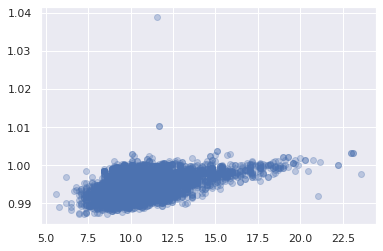

In [17]:
# in the line below, use model.predict() and provide wine['fixed acidity'] as 
# the input data to predict what wine['density'] will be
# y_pred = 

plt.plot(y_pred, wine['density'], ls='', marker='o', alpha=0.3)

<a name='x.2'></a>

## 1.2 Neural Network Architectures

[back to top](#top)



<a name='x.2.1'></a>

###1.2.1 Neural Network Layers

[back to top](#top)

Now that we have the idea of the most basic building block of a neural network, we will start to discuss the larger architecture. The reason we focused on the lowest building block, is that neural networks are _modular_. They are made up of instances of these perceptrons or neurons. neurons in parallel make up a _layer_

<p align=center>
<img src="https://i.imgur.com/2MA4iMV.png"></img>
<p>

These layers feed into one another. When each node of a preceding layer is connected to every node of a following layer, we say they are _fully connected_ and the receiving layer is _a dense layer_. In a moment we will talk about input, output and hidden layers, for neural networks with three or more layers.

<a name='x.2.2'></a>

### 1.2.2 The Activation Function

[back to top](#top)

It turns out that stringing together a bunch of linear functions, will still result in overall linear relationships. We need a way to break out of this. A neat trick is introduced at the output of each neuron. The output passes through an _activation function_. There are a handful of different activation functions used in practice, the most common is known as the _rectifier_ function:

$$ max(f(x), 0) $$

and the resulting node can be schematically drawn like this:

<p align=center>
<img src="https://i.imgur.com/eFry7Yu.png"></img>
</p>

with the inset of the summation node indicating that at a minimum the resultant y value is 0.

#### 1.2.2.1 Exercise: The Rectifier Function

Write a function called `my_perceptron` that takes x, a length 2 array, as an input. Have your function return the maximum of $(0, w*x + b)$ where w is a length 2 weight vector.

In [18]:
def my_perceptron(x):
  """
  a simple 2 input feature perceptron with predefined weights, intercept, and 
  a rectifier activation function

  Parameters
  ----------
  x: array
    the input array of length 2

  Returns
  -------
  rect: int
    the rectified output of the perceptron
  """

  # # define b, w, and y (y=mx+b)
  # w = 
  # b = 
  # y = 

  # # return the max of 0 and y
  # rect = 
  return rect

After you write your function make sure it returns 0 when the output of the linear component is negative.

In [19]:
def test_zero_output():
  x = np.array([-10,-10]) # 10 * 1 + (-10) * 2 + 1 = -11
  assert my_perceptron(x) == 0, "The output is not zero when it should be!"

In [20]:
test_zero_output()
print("test passing")

test passing


<a name='x.2.3'></a>

### 1.2.3 Stacking Layers

[back to top](#top)

When we stack many layers together, we create what are traditionally regarded as neural networks. the first and last layers are called the _input_ and _output_ layers, while the inbetween layers are referred to as _hidden_ layers, since their outputs are not directly seen. Tradditionally, a neural network with three or more hidden layers is referred to as a _deep_ neural network.

<p align=center>
<img src="https://i.imgur.com/Y5iwFQZ.png"></img
</p>

Notice that in this schematic, the last node does not have an activation function. This is typical of a regression task. In a classification task, we might require an activation function here.

<a name='x.2.2'></a>

### 1.2.2 Building Sequential Neural Networks

[back to top](#top)

Now that we have the essential components of a neural network architecture, we can enter into the domain of overall naming conventions for architecure types. The classic neural network architecture is a _feed forward_ neural network, where every preceding layer feeds into the next layer. We will practice building that with keras.

### 1.2.5 Exercise: Building Sequential Layers

In the cell bellow, use keras to build a 3-layer network with `activation='relu'` and 512 units. Create the output layer so that it can predict 1 continuous value.

In [23]:
# Cell for exercise 1.1.5

# DECLARE THE MODEL

model = keras.Sequential([
                          
    ### YOUR CODE HERE ###

    # the hidden ReLU layers

    # the linear output layer 
    
])

### 1.2.6 Exercise: Other Activation Functions

There are other activation functions we can use after the summation in a neural node. Use the code below to plot and inspect them!

Pick one and do a quick google search on what that activation function's best use case is.

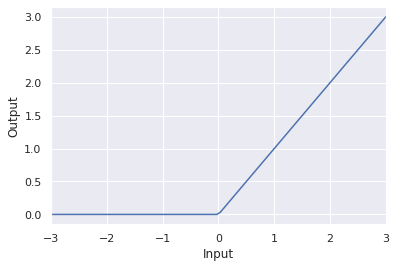

In [37]:
import tensorflow as tf

# YOUR CODE HERE: Change 'relu' to 'elu', 'selu', 'swish'... or something else
activation_layer = layers.Activation('relu')

x = tf.linspace(-3.0, 3.0, 100)
y = activation_layer(x) # once created, a layer is callable just like a function

plt.plot(x, y)
plt.xlim(-3, 3)
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

<a name='x.3'></a>

## 1.3 Neural Network Training

[back to top](#top)

We've defined neural network architectures, now how do we train them? There are two main concepts here: the _loss function_ which we've encountered before, and the _optimizer_ the means by which we improve the loss function

<a name='x.3.1'></a>

### 1.3.1 The Loss Function

[back to top](#top)

In previous sessions, we've envountered MSE:

$$ MSE = \frac{1}{N}\sum{(y-\hat{y})^2}$$

<p align=center>
<img src="https://cdn.corporatefinanceinstitute.com/assets/Sum-of-Squares-1024x712.png" width=400></img>
</p>

Another common loss for neural networks is the mean absolute error (MAE):

$$ MAE = \frac{1}{N}\sum{|y-\hat{y}|}$$

<p align=center>
<img src="https://cdn-media-1.freecodecamp.org/images/MNskFmGPKuQfMLdmpkT-X7-8w2cJXulP3683" width=400></img>
</p>

In anycase, the loss function describes the difference between the actual and predicted output of the model. The important thing to note, is that the weights in the neural network are systematically updated according to this loss function, they do this via an optimization algorithm.

<a name='x.3.2'></a>

### 1.3.2 The Optimizer

[back to top](#top)

In order to update the neural network weights to improve the loss function, we require an algorithm. Virtually all available algorithms for this purpose fall within the family of _stochastic gradient descent_. This works essentially in these iterative steps:

1. a subsample of the input data is passed through the network 
2. a loss is computed
2. the weights are adjusted in a direction to improve the loss

> The key here is in step 3. The brilliance of neural networks, is that the loss function is differentiable with respect to the weights in the network, and so the change in loss can be ascribed to certain weight changes. We refer to this as _assigning blame_ in the network, and it works through the mathematical _chain rule_ of differentiation. We won't go into great detail here, other than to make a nod to it, and that this algorithm (step 3) is referred to as _back propagation_. 

The three step process is repeated until a stop criteria is reached, the simplest being the loss stops improving above some threshold or a desired loss is achieved. 

<p align=center>
<img src="https://i.imgur.com/rFI1tIk.gif"></img>
</p>

In the above animation, the black line represents the output of the model, the red dots make up a _minibatch_ or simply a _batch_ while the opaque red dots represent the whole training dataset. Exposing the model to an entire round of the training data is referred to as an _epoch_. The training loss improves with additional rounds of trianing (middle panel) and the weights are adjusted to update the model (right panel).


### 1.3.3 Batches and Epochs

An epoch is the number of times the model will see the entire training set

A batch is the number of training samples the model will run before calculating a total error and updating its internal parameters. 

Variability of batch (from 1 sample all the way to the entire training set size) leads to different categorizations of the optimizer algorithm:

* Batch Gradient Descent. Batch Size = Size of Training Set
* Stochastic Gradient Descent. Batch Size = 1
* Mini-Batch Gradient Descent. 1 < Batch Size < Size of Training Set

We will visit additional details about batch and epochs in the next session when we discuss model evaluation.

<a name='x.3.3'></a>

### 1.3.4 Learning Rate

[back to top](#top)

notice how in the above animation the model makes progressive steps toward a global optimum. The size of these steps is determined by the _learning rate_. You can think of it as the amount of improvement to make in the direction of steepest descent (the derivative of the loss function in regards to the changes in weights). Sometimes a large step size can result in stepping over crevices in the solution surface and getting stuck, while too small of step sizes can lead to a slow algorithm. Often the optimum learning rate is not obvious, luckily there are some optimizers that are self-calibrating in this regard. _Adam_ is one such optimizer available to us in keras. 

In [26]:
# we can compile the model like so
model.compile(
    optimizer="adam",
    loss="mae",
)

### 1.3.5 Exercise: Train your first Neural Networks

[back to top](#top)

We're going to train our first neural network.

Take the model you created in exercise 1.2.5 and paste it in the cell below. Make sure that the `input_shape` of the first layer matches the number of features in `X_train_std`

In [27]:
X_train_std.shape[1]

13

In [30]:
# Cell for exercise 1.1.5

# DECLARE THE MODEL

model = keras.Sequential([
                          
    ### YOUR CODE HERE ###

    # the hidden ReLU layers

    # the linear output layer 
    
])

Now we'll compile the model

In [31]:
model.compile(
    optimizer='adam',
    loss='mse',
)

And then train for 10 epochs

In [32]:
history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
15/15 [==============================] - 1s 33ms/step - loss: 0.6389 - val_loss: 0.1925
Epoch 2/10
15/15 [==============================] - 0s 22ms/step - loss: 0.1330 - val_loss: 0.1054
Epoch 3/10
15/15 [==============================] - 0s 22ms/step - loss: 0.0739 - val_loss: 0.0587
Epoch 4/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0442 - val_loss: 0.0378
Epoch 5/10
15/15 [==============================] - 0s 22ms/step - loss: 0.0266 - val_loss: 0.0283
Epoch 6/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0193 - val_loss: 0.0233
Epoch 7/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0165 - val_loss: 0.0212
Epoch 8/10
15/15 [==============================] - 0s 22ms/step - loss: 0.0151 - val_loss: 0.0204
Epoch 9/10
15/15 [==============================] - 0s 22ms/step - loss: 0.0144 - val_loss: 0.0199
Epoch 10/10
15/15 [==============================] - 0s 23ms/step - loss: 0.0140 - val_loss: 0.0194


Let's take a look at our training history:

In [35]:
pd.DataFrame(history.history)

,loss,val_loss
0,0.638868,0.192506
1,0.133038,0.105378
2,0.073934,0.058686
3,0.044192,0.037832
4,0.026648,0.028253
5,0.019265,0.023272
6,0.016508,0.021151
7,0.015126,0.020368
8,0.014371,0.019929
9,0.014009,0.019429


(0.0, 0.05)

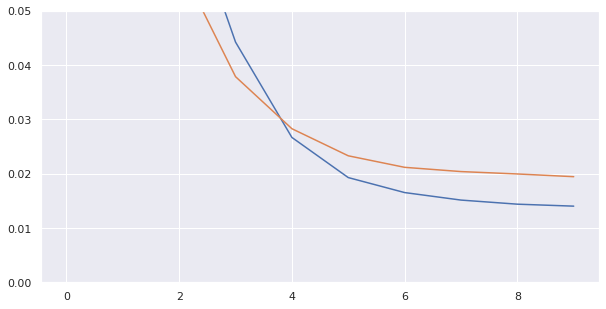

In [36]:
# convert the training history to a dataframe
history_df = pd.DataFrame(history.history)
# use Pandas native plot method
fig, ax = plt.subplots(figsize=(10,5))
history_df['loss'].plot(ax=ax)
history_df['val_loss'].plot(ax=ax)
ax.set_ylim(0,.05)

#### 1.3.5.1 Improve loss by varying nodes and hidden layers

Take your former model as a starting point and now either add nodes or layers to see if the model improves

In [ ]:
model = keras.Sequential([
    ### YOUR CODE HERE ###
    
])

model.compile(
    optimizer='adam',
    loss='mse',
)

history = model.fit(
    X_train_std, y_train_std,
    validation_data=(X_val_std, y_val_std),
    batch_size=256,
    epochs=10,
)

Epoch 1/10
15/15 [==============================] - 1s 11ms/step - loss: 3.0090 - val_loss: 1.9299
Epoch 2/10
15/15 [==============================] - 0s 4ms/step - loss: 1.3536 - val_loss: 0.7737
Epoch 3/10
15/15 [==============================] - 0s 3ms/step - loss: 0.4739 - val_loss: 0.2300
Epoch 4/10
15/15 [==============================] - 0s 4ms/step - loss: 0.1334 - val_loss: 0.0781
Epoch 5/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0592 - val_loss: 0.0471
Epoch 6/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0402 - val_loss: 0.0354
Epoch 7/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0335 - val_loss: 0.0325
Epoch 8/10
15/15 [==============================] - 0s 4ms/step - loss: 0.0311 - val_loss: 0.0305
Epoch 9/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0288
Epoch 10/10
15/15 [==============================] - 0s 3ms/step - loss: 0.0274 - val_loss: 0.0271


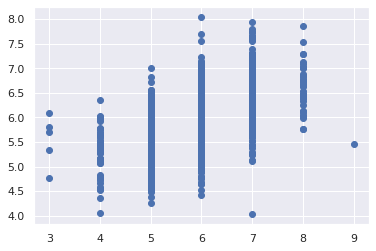

In [ ]:
y_pred = model.predict(X_test_std)
plt.plot(np.exp(y_test_std), np.exp(y_pred), ls='', marker='o')

#### 1.3.5.2 Learning Curves

Using 4 hidden layers now create 4 models that run for 30 epochs each:

1. Vary the number of nodes in each layer
2. Record the train/val/test score (MSE)
3. Plot either total nodes or total trainable parameters vs score for each of the 5 models

In [ ]:
# Code Cell for Exercise 1.3.5

,tot. units,test mse,val mse,train mse
0,4,0.030658,0.030919,0.031088
1,25,0.020217,0.020164,0.019062
2,100,0.017429,0.018110,0.017416
3,289,0.019124,0.019371,0.018190


When we look at our historical loss do we notice that sometimes before the last epoch we actually hit a minimum? We'll discuss how to deal with this in the next session!